<h1><center> Apprentissage non supervisé avec GraphSAGE sur le product Space </center></h1>

<center> Kévin CORTIAL &nbsp;&nbsp;&nbsp; | &nbsp;&nbsp;&nbsp; Open Studio UCA IP / Atlas des Synergies Productives &nbsp;&nbsp;&nbsp; | &nbsp;&nbsp;&nbsp; 19/09/2022 &nbsp;&nbsp;&nbsp; | &nbsp;&nbsp;&nbsp; updated on 24/11/2022 </center>

Librairies nécessaires

In [1]:
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt

import numpy as np

from stellargraph import StellarGraph
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph import datasets

import tensorflow as tf
from tensorflow import keras

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import rand_score

# Chargement du graph dans Networkx
- Prétraitement des données, nettoyage, .. etc

In [2]:
# DataFrame avec les scores des arrêtes :

url = 'https://raw.githubusercontent.com/kevinCortial/graphlearning/main/Product_Space/data/HS_similarity_score.csv'

edges_data = pd.read_csv(url,  sep="|", dtype={'code_hs4': object, 'code_hs4_linked': object})

test = 'https://github.com/kevinCortial/graphlearning/blob/main/Product_Space/data/HS_similarity_vectors_picklepickle.csv?raw=true'
# Load data pour les noeuds
edges_vector = pd.read_pickle(test)
#edges_vector = pd.read_pickle('/Users/cortial/Documents/Graph_coding/graph-learning/HS_similarity_vectors_picklepickle.csv')
# Suppression des noeuds ayant un coefficient à zéro
data_no_zero = edges_vector[edges_vector['score'] != 0]
data_no_zero.head(3)

,code_hs4,code_hs4_linked,score,name_en,name_en_linked,vector_hs4,vector_hs4_linked
0,0102,0103,0.678185,Live bovine animals,Live swine,"[0.0032881612, -7.232755e-05, 0.0048421538, 0....","[0.0028440768, -0.0012178234, 0.0024635517, -0..."
1,0102,0104,0.759883,Live bovine animals,Live sheep and goats,"[0.0032881612, -7.232755e-05, 0.0048421538, 0....","[0.0010539496, -0.00232635, -0.001710704, -0.0..."
2,0102,0105,0.827451,Live bovine animals,Live poultry \fowls of the species Gallus dome...,"[0.0032881612, -7.232755e-05, 0.0048421538, 0....","[0.0045550014, 0.0012042683, 0.0017062741, -0...."


In [3]:
# Création du graph Networkx à partir d'une matrice d'adjacence

df = pd.crosstab(data_no_zero.code_hs4, data_no_zero.code_hs4_linked, dropna=False)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)

In [4]:
# Suppression des petits graphes avec une faible centralité
centrality = nx.closeness_centrality(G)
centrality_sort = {k: v for k, v in sorted(centrality.items(), key=lambda item: item[1])}

label_mini_graph = list(centrality_sort.keys())[0:21]

DiGraph with 718 nodes and 5597 edges


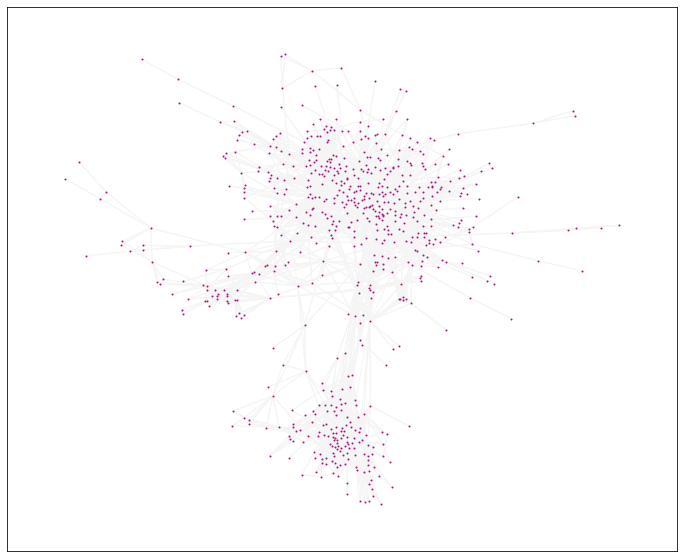

In [5]:
print(nx.info(G))
plt.figure(figsize=(12, 10))
G.remove_nodes_from(label_mini_graph)
nx.draw_networkx(G, node_size=1, with_labels=False, arrowsize=0.1, node_color='#ac1480', edge_color='whitesmoke')
plt.show()
#G = G.to_undirected()

In [6]:
#Suppression des lignes de données de ces mini graphes

index_mini_graph_1 = []
index_mini_graph_2 = []

for i in label_mini_graph:
    index_mini_graph_1.append(data_no_zero[data_no_zero['code_hs4'].str.contains(i)].index.values)
    index_mini_graph_2.append(edges_data[edges_data['code_hs4'].str.contains(i)].index.values)
    index_mini_graph_2.append(edges_data[edges_data['code_hs4_linked'].str.contains(i)].index.values)
    
data_no_zero = data_no_zero.drop(list(np.concatenate(index_mini_graph_1).flat))
edges_data = edges_data.drop(list(np.concatenate(index_mini_graph_2).flat))

In [7]:
# Remplis les noeuds du graphe avec des data
for node_data in list(G.nodes(data=True)):
    G.nodes[node_data[0]]['data'] = data_no_zero[data_no_zero['code_hs4'] == node_data[0]].iloc[0, 5].ravel()
    
# Remplis les arêtes du graphe
for i in edges_data.index.values:
    G.edges[edges_data.loc[i,'code_hs4'], edges_data.loc[i,'code_hs4_linked']]['score_arnault'] = edges_data.loc[i,'score']
    G.edges[edges_data.loc[i,'code_hs4'], edges_data.loc[i,'code_hs4_linked']]['score_taoufik'] = edges_data.loc[i,'similarity_score']

In [8]:
# Utilisation des catégories "Secteur d'activité des entreprises"
url_data_categorie = 'https://github.com/kevinCortial/graphlearning/blob/main/Product_Space/data/data_categorie_hs.csv?raw=true'
categories_hs = pd.read_csv('/Users/cortial/Downloads/data-1660308901789.csv', dtype={'code_hs4': object, 
                                                                                      'macro_sector_id': object,
                                                                                      'macro_sector_naf_id': object})
categories_hs = categories_hs[['code_hs4', 'macro_sector_id', 'macro_sector_naf_id']]
categories_hs.macro_sector_id.fillna(categories_hs.macro_sector_naf_id, inplace=True)

In [9]:
categories_hs.dtypes
categories_hs['macro_sector_id'] = categories_hs['macro_sector_id'].astype('int64')

In [10]:
# Remplis les noeuds du graphe avec ces catégories
for node_data in list(G.nodes(data=True)):
    G.nodes[node_data[0]]['categorie_macro'] = categories_hs[categories_hs['code_hs4'] == node_data[0]].iloc[0, 1]

In [11]:
# Vizualisation des données présent dans les deux premiers noeuds du graph
list(G.nodes(data=True))[-1]

('9702',
 {'data': array([ 1.08811969e-03,  3.31011717e-03, -2.77593732e-04, -1.01437245e-03,
          2.93128192e-03, -4.48912801e-03,  1.84991950e-04, -6.39753067e-04,
         -1.79961440e-03, -4.82683908e-03,  4.81023733e-03, -8.69349809e-04,
          2.99863808e-04,  2.89257756e-03, -1.96885131e-03,  2.53269309e-03,
          2.51151971e-03, -3.89114313e-04, -2.70129438e-03, -1.07372405e-04,
         -2.12158589e-03, -2.18460243e-03,  3.20108305e-03,  2.36525247e-03,
         -1.02221791e-03, -5.51855250e-04, -2.75860424e-04,  1.88235636e-03,
         -2.91542779e-03, -3.37130181e-03, -2.34717247e-03, -1.91792008e-03,
         -3.99097195e-03,  8.92387645e-04,  1.68913428e-03,  4.06169752e-03,
          3.32981363e-05,  1.66556245e-04, -3.35586839e-03,  2.21151998e-03,
         -1.35082635e-03,  4.38983273e-03,  3.84913670e-04, -7.24570767e-04,
         -1.76845794e-03, -4.62271227e-03, -2.20408500e-03,  3.44693963e-03,
          4.43214178e-03, -1.69394759e-03,  4.01234254e-03,

In [12]:
# Sauvegarde du graph NetworkX dans un fichier
#nx.write_gpickle(G, "/Users/cortial/Documents/Graph_coding/product_graphWithData4int.gpickle", protocol=4)

# Apprentissage des embeddings avec une méthode nonsupervisé graphSAGE

L'application d'un GraphSAGE non supervisé, permet de prendre en compte les caractéristiques des nœuds ainsi que **la structure du graphe**. 

Le but est de **produire de nouveaux embeddings de nœuds en utilisant uniquement la structure du graphe**. De plus dans notre cas, nous n'utilisons pas d'étiquettes de classe/labels de nœuds connues (d'où le terme "non supervisé") car notre but final sera de faire du clustering avec les nouveaux embeddings afin de détecter des communautés dans le graphe.

In [13]:
# Convertir de la class NetworkX to StellarGraph
gstellar = StellarGraph.from_networkx(G, node_features='data', edge_weight_attr='score_taoufik')
print(gstellar.info())

StellarDiGraph: Directed multigraph
 Nodes: 697, Edges: 5556

 Node types:
  default: [697]
    Features: float32 vector, length 100
    Edge types: default-default->default

 Edge types:
    default-default->default: [5556]
        Weights: range=[-0.342485, 0.295836], mean=0.000165418, std=0.0987356
        Features: none


Le modèle GraphSAGE non supervisé fonctionne en mettant à jour les embeddings de nœuds en résolvant une tâche de classification simple.

Pour cela, des paires de nœuds "positives" sont générées à partir de marches aléatoires effectuées sur le graphe.
Un autre ensemble également grand de paires de nœuds "négatives" qui sont sélectionnées aléatoirement dans le graphe selon une certaine distribution (souvent lié au degrés de connection dans le graphe).

Exemple de visualisation : https://snap.stanford.edu/graphsage/

L'apprentissage de ce classificateur binaire permet de prédire si des paires de nœuds arbitraires sont susceptibles de coïncider dans une marche aléatoire effectuée sur le graphe. Grâce à l'apprentissage de cette tâche simple de classification binaire des paires de nœuds, le modèle apprend automatiquement un mappage inductif des attributs des nœuds et de leurs voisins vers des encastrements de nœuds dans un espace vectoriel à haute dimension, qui préserve les similarités structurelles et fonctionnelles des nœuds. 

Contrairement aux encastrements obtenus par des algorithmes tels que Node2Vec, cette correspondance est inductive : étant donné un nouveau nœud (avec des attributs) et ses liens vers d'autres nœuds du graphe (qui n'a pas été vu pendant l'apprentissage du modèle), nous pouvons évaluer ses encastrements sans avoir à ré-entraîner le modèle.

In [14]:
# parameter specification
nodes = list(G.nodes())
number_of_walks = 1
length = 2

In [15]:
unsupervised_samples = UnsupervisedSampler(
    gstellar, nodes=nodes, length=length, number_of_walks=number_of_walks
)

The architecture of the node pair classifier is the following. Input node pairs (with node features) are fed, together with the graph structure, into a pair of identical GraphSAGE encoders, producing a pair of node embeddings. These embeddings are then fed into a node pair classification layer, which applies a binary operator to those node embeddings (e.g., concatenating them), and passes the resulting node pair embeddings through a linear transform followed by a binary activation (e.g., sigmoid), thus predicting a binary label for the node pair.

The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted node pair labels and true link labels) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links generated on demand and fed into the model.

Node embeddings obtained from the encoder part of the trained classifier can be used in various downstream tasks. In this demo, we show how these can be used for predicting node labels.

In [16]:
batch_size = 50
epochs = 4
num_samples = [10, 5]
layer_sizes = [50, 50]
learning_rate = 1e-2

#Olalalalala que c'est compliqué je ne sais pas 

In [17]:
generator = GraphSAGELinkGenerator(gstellar, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

In [18]:
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)

In [19]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

In [20]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [21]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=0, patience=3)

history = model.fit(
    train_gen,
    epochs=100,
    verbose=0,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
    callbacks=[callback]
)

In [23]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [24]:
node_ids = list(G.nodes)
node_gen = GraphSAGENodeGenerator(gstellar, batch_size, num_samples).flow(node_ids)

In [25]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

14/14 [==============================] - 1s 19ms/step


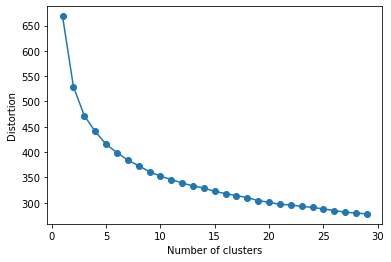

In [26]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 30):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(node_embeddings)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 30), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

kmeans = KMeans(n_clusters=19, random_state=0).fit(node_embeddings)

In [27]:
metrics.adjusted_rand_score(list(dict(G.nodes.data('categorie_macro')).values()),
                           list(kmeans.labels_))

0.059591612538359026

In [28]:
metrics.adjusted_rand_score(list(dict(G.nodes.data('categorie_macro')).values()),
                           list(kmeans.labels_))

0.059591612538359026

In [29]:
metrics.adjusted_rand_score(list(dict(G.nodes.data('categorie_macro')).values()),
                           list(kmeans.labels_))

0.059591612538359026

In [30]:
result = [0.0817028066237117, 0.059590233331490335, 0.08461223897390889]

In [31]:
np.mean(result)

0.07530175964303698

In [32]:
np.std(result)

0.011173040273471085

# Cora dataset

In [33]:
dataset = datasets.Cora()
G, node_subjects = dataset.load()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [34]:
nodes = list(G.nodes())
number_of_walks = 1
length = 5
batch_size = 50
epochs = 4
num_samples = [10, 5]
layer_sizes = [50, 50]

unsupervised_samples = UnsupervisedSampler(G, nodes=nodes, length=length, number_of_walks=number_of_walks)
generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)
graphsage = GraphSAGE(layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2")
x_inp, x_out = graphsage.in_out_tensors()
prediction = link_classification(output_dim=1, output_act="sigmoid", edge_embedding_method="ip")(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


/Users/cortial/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=0, patience=3)

history = model.fit(
    train_gen,
    epochs=100,
    verbose=0,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
    callbacks=[callback]
)

In [36]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)
node_ids = node_subjects.index
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(node_ids)
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

55/55 [==============================] - 2s 25ms/step


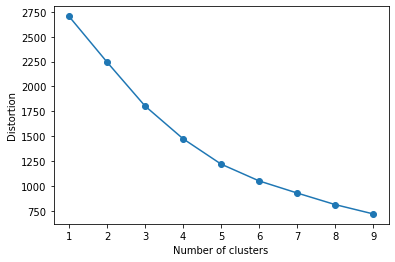

In [37]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 10):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(node_embeddings)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


kmeans = KMeans(n_clusters=7, random_state=0).fit(node_embeddings)

In [38]:
le = preprocessing.LabelEncoder()
le.fit(node_subjects)
list(le.classes_)
label_true = le.transform(node_subjects)

In [39]:
metrics.adjusted_rand_score(label_true,
                           list(kmeans.labels_))

0.3867261592858465

In [40]:
metrics.adjusted_rand_score(label_true,
                           list(kmeans.labels_))

0.3867261592858465

In [41]:
metrics.adjusted_rand_score(label_true,
                           list(kmeans.labels_))

0.3867261592858465

In [42]:
result = [0.4100377288254731, 0.4077179091098509, 0.4537247271439902]

In [43]:
np.mean(result)

0.42382678835977144

In [44]:
np.std(result)

0.021162237571311124